<a href="https://colab.research.google.com/github/vmpreciado/NETS3120/blob/main/TwitterDegree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Twitter Degrees Lab --- Loading and Exploring a Social Graph

In this notebook we study **degree-based structure** in a real directed social network using a subgraph of Twitter/X.

We will:
1. **Load** a previously saved directed graph (GraphML).
2. Inspect basic properties: number of nodes/edges, directedness, and a quick preview.
3. Compute and visualize **in-degree** and **out-degree** statistics and distributions.

> **Note:** The graph has already been constructed in a previous notebook ('TwitterImport.ipynb') and saved to disk.
> This notebook is self-contained: you only need the exported GraphML file.

In [1]:
import networkx as nx
from pathlib import Path

# ------------------------------------------------------------
# Load a previously saved Twitter/X subgraph (GraphML format)
#
# Assumes the file was saved earlier to:
#   data/twitter_graph.graphml
#
# If you saved it elsewhere, update `out_dir` and/or the filename.
# ------------------------------------------------------------

# Folder where the graph was saved
out_dir = Path("data")

# Path to the GraphML file
graphml_path = out_dir / "twitter_graph.graphml"

# Safety check: give a clear message if the file is missing
if not graphml_path.exists():
    raise FileNotFoundError(
        f"Could not find the GraphML file at:\n  {graphml_path.resolve()}\n\n"
        "Fix options:\n"
        "  1) Make sure the file exists in the notebook folder under data/.\n"
        "  2) Update `out_dir` or `graphml_path` to the correct location.\n"
        "  3) Re-run the previous notebook cell that exports the graph to GraphML.\n"
    )

# Load the graph
X = nx.read_graphml(graphml_path)

# Basic sanity checks / summary
print("Reloaded graph:")
print(f"  path:     {graphml_path}")
print(f"  directed: {X.is_directed()}")
print(f"  nodes:    {X.number_of_nodes():,}")
print(f"  edges:    {X.number_of_edges():,}")

Reloaded graph:
  path:     data/twitter_graph.graphml
  directed: True
  nodes:    81,306
  edges:    1,768,149


## Degree Sequences in a Directed Social Network
### In-degrees and Out-degrees

With the directed graph `X` loaded in memory, we now begin a basic
structural analysis of the network.

Our first goal is to compute the **in-degree** and **out-degree sequences**:
- the *in-degree* of a node counts how many edges point **to** it,
- the *out-degree* of a node counts how many edges point **from** it.

These two sequences provide a first quantitative description of how
connectivity and influence are distributed across the network.

In [2]:
# ------------------------------------------------------------
# Compute in-degree and out-degree sequences
# ------------------------------------------------------------

# NetworkX returns DegreeView objects: (node, degree) pairs
in_degrees = X.in_degree()
out_degrees = X.out_degree()

# Extract only the degree values, preserving the node order
in_degree_sequence = [d for _, d in in_degrees]
out_degree_sequence = [d for _, d in out_degrees]

# Quick sanity check
n = len(in_degree_sequence)

avg_in_degree = sum(in_degree_sequence) / n
avg_out_degree = sum(out_degree_sequence) / n

print("Degree sequences computed:")
print(f"  number of nodes:        {n}")
print(f"  min / max in-degree:   {min(in_degree_sequence)} / {max(in_degree_sequence)}")
print(f"  min / max out-degree:  {min(out_degree_sequence)} / {max(out_degree_sequence)}")
print(f"  average in-degree:     {avg_in_degree:.3f}")
print(f"  average out-degree:    {avg_out_degree:.3f}")

Degree sequences computed:
  number of nodes:        81306
  min / max in-degree:   0 / 3383
  min / max out-degree:  0 / 1205
  average in-degree:     21.747
  average out-degree:    21.747


### In-degree vs. Out-degree Histograms

We now visualize the **distribution of in-degrees and out-degrees** in the
Twitter/X subgraph.

Histograms allow us to see:
- how node connectivity is distributed,
- whether most nodes have low degree,
- and whether a small number of nodes act as superconnected hubs.

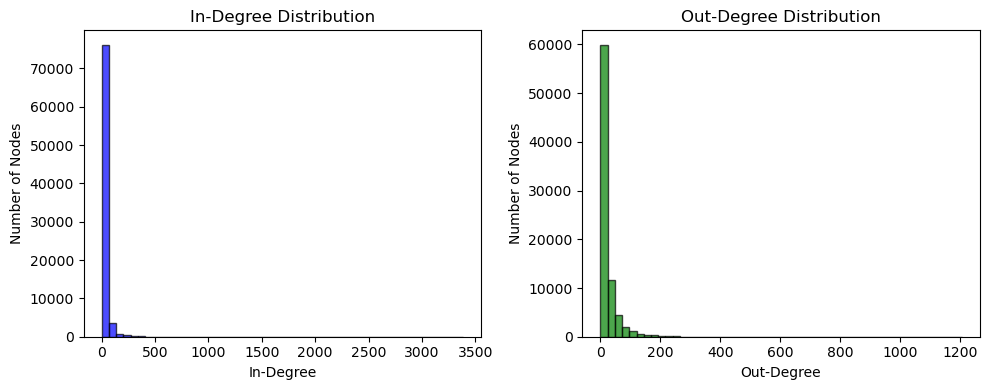

In [3]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Histograms of in-degree and out-degree
# ------------------------------------------------------------

# Choose a reasonable number of bins.
# Using too many bins can be misleading for heavy-tailed distributions.
num_bins = 50

plt.figure(figsize=(10, 4))

# --- In-degree histogram ---
plt.subplot(1, 2, 1)
plt.hist(
    in_degree_sequence,
    bins=num_bins,
    color='blue',
    alpha=0.7,
    edgecolor='black'
)
plt.title("In-Degree Distribution")
plt.xlabel("In-Degree")
plt.ylabel("Number of Nodes")

# --- Out-degree histogram ---
plt.subplot(1, 2, 2)
plt.hist(
    out_degree_sequence,
    bins=num_bins,
    color='green',
    alpha=0.7,
    edgecolor='black'
)
plt.title("Out-Degree Distribution")
plt.xlabel("Out-Degree")
plt.ylabel("Number of Nodes")

plt.tight_layout()
plt.show()

### Interpreting Degree Distributions: Skewness, Hubs, and the Need for Log–Log Plots

An intriguing pattern emerges from the histograms above:
most nodes have **very small in-degrees and out-degrees**, while a **small number of nodes**
exhibit extremely large degrees.

This is already evident from the summary statistics computed earlier:
- the **maximum in-degree** is 3,383
- the **maximum out-degree** is 1,205.

These values are orders of magnitude larger than the average degree ($\sim$21.7) and correspond to
**highly connected nodes (hubs)** in the network.

Such a disparity between typical and extreme values leads to a **strongly skewed distribution**.
This phenomenon is analogous to **wealth distributions in capitalist societies**, where
most individuals have modest wealth and a small fraction controls a disproportionately
large share of resources.

Because the range of degree values spans several orders of magnitude, standard linear-scale
histograms can hide important structure in the tail of the distribution.
A more informative representation is obtained by plotting:

> **Degree vs. frequency on logarithmic scales (log–log plots).**

Log–log visualizations allow us to:
- clearly observe heavy-tailed behavior,
- assess whether the distribution follows a power-law–like decay,
- distinguish between random and highly heterogeneous network structures.

In the next cell, we will construct **log–log plots of the degree distributions**
to better understand the presence and role of hubs in the network.

Log-log degree-frequency data (zeros removed):
  distinct in-degrees:  573   (max in-degree:  3383)
  distinct out-degrees: 380  (max out-degree: 1205)


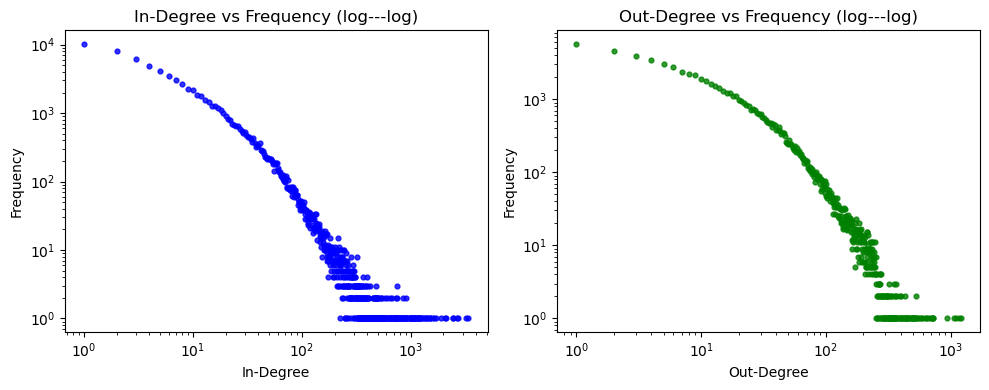

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def degree_frequency(degree_sequence, drop_zero=True):
    """
    Convert a list of degrees into two aligned numpy arrays:
      degrees = [d_1, d_2, ...]
      counts  = [count(d_1), count(d_2), ...]

    Parameters
    ----------
    degree_sequence : list[int]
        Degrees for all nodes.
    drop_zero : bool
        If True, remove degree 0 (helps log-log plots).
    """
    counts = Counter(degree_sequence)

    # Optionally drop degree-0 nodes (log-scale can't plot x=0)
    if drop_zero and 0 in counts:
        counts.pop(0)

    # Sort by degree for nicer plots
    degrees = np.array(sorted(counts.keys()), dtype=int)
    freq = np.array([counts[d] for d in degrees], dtype=int)

    return degrees, freq

# Compute degree-frequency data
in_deg_vals, in_freq = degree_frequency(in_degree_sequence, drop_zero=True)
out_deg_vals, out_freq = degree_frequency(out_degree_sequence, drop_zero=True)

# Quick summary for students
print("Log-log degree-frequency data (zeros removed):")
print(f"  distinct in-degrees:  {len(in_deg_vals)}   (max in-degree:  {in_deg_vals.max() if len(in_deg_vals)>0 else 0})")
print(f"  distinct out-degrees: {len(out_deg_vals)}  (max out-degree: {out_deg_vals.max() if len(out_deg_vals)>0 else 0})")

# Plot: Degree vs Frequency on log-log scale
plt.figure(figsize=(10, 4))

# In-degree
plt.subplot(1, 2, 1)
plt.scatter(in_deg_vals, in_freq, color='blue', s=12, alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.title("In-Degree vs Frequency (log---log)")
plt.xlabel("In-Degree")
plt.ylabel("Frequency")

# Out-degree
plt.subplot(1, 2, 2)
plt.scatter(out_deg_vals, out_freq, color='green', s=12, alpha=0.8)
plt.xscale("log")
plt.yscale("log")
plt.title("Out-Degree vs Frequency (log---log)")
plt.xlabel("Out-Degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Heavy-Tailed Degree Distributions in Social Networks

A common feature of most online social networks, including Twitter/X, is a
**highly skewed (heavy-tailed) degree distribution**. In such networks,
a small number of nodes accumulate a disproportionately large number of
connections, while the vast majority of nodes have relatively few.

This heterogeneity is often interpreted as the presence of **hubs** and is
fundamentally different from what one would expect in homogeneous or random
networks.

A classical theoretical explanation for this phenomenon is the
**“rich-get-richer” mechanism**, also known as *preferential attachment*:
nodes that already have many connections are more likely to attract new ones,
leading to cumulative advantage over time.

## In-Degree vs. Out-Degree: Influence vs. Choice in Directed Social Networks

A distinctive feature of directed social networks such as Twitter/X is the
**asymmetry between in-degrees and out-degrees**.

- **In-degree** represents how many followers a user has — a measure of
  *social attention or influence* that is largely outside the user’s direct control.
- **Out-degree** represents how many accounts a user chooses to follow — a
  measure of *individual choice and activity*.

To explore how these two quantities relate, we visualize each node as a point
in the plane with coordinates
$$
(\text{in-degree},\ \text{out-degree}).
$$

This scatter-plot analysis helps us understand whether highly influential users
also tend to be highly active, or whether influence and activity are largely
decoupled in the network.

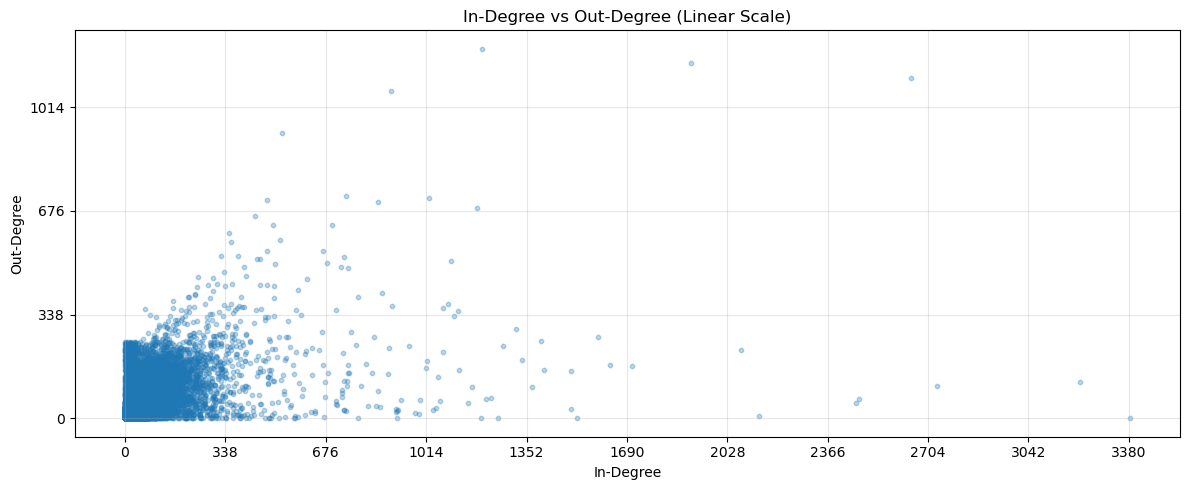

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Scatter plot: In-degree vs Out-degree (linear scale)
# ------------------------------------------------------------

plt.figure(figsize=(12, 5))

plt.scatter(
    in_degree_sequence,
    out_degree_sequence,
    s=10,
    alpha=0.3
)

plt.xlabel("In-Degree")
plt.ylabel("Out-Degree")
plt.title("In-Degree vs Out-Degree (Linear Scale)")

# Set tick spacing based on data range (avoid clutter)
max_in_degree = max(in_degree_sequence)
max_out_degree = max(out_degree_sequence)

step = max(1, max(max_in_degree, max_out_degree) // 10)
plt.xticks(np.arange(0, max_in_degree + 1, step))
plt.yticks(np.arange(0, max_out_degree + 1, step))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Why Linear Scale Is Not Enough

In the linear-scale scatter plot above, most of the points are crowded near the
origin. This happens because:

- the **majority of nodes have very small in-degrees and out-degrees**, and
- a **small number of nodes have extremely large degrees**.

As a result, the wide range of degree values causes:
- dense overlap among low-degree nodes,
- poor visibility of high-degree nodes,
- and loss of structural information in the tail of the distribution.

This issue is not a plotting artifact—it reflects a fundamental property of
social networks: **degrees span several orders of magnitude**.

To better visualize relationships across this entire range, we next use a
**log–log scale**, which:
- spreads out low-degree nodes,
- compresses extreme values,
- and reveals patterns that are hidden on a linear scale.

This transformation allows us to meaningfully compare nodes with very different
levels of connectivity.

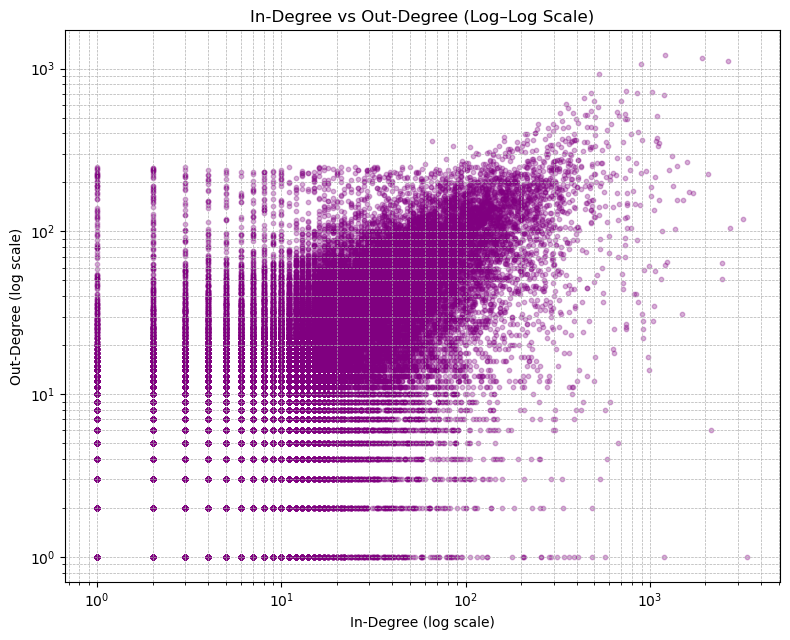

In [6]:
# ------------------------------------------------------------
# Scatter plot: In-degree vs Out-degree (log–log scale)
# ------------------------------------------------------------

# Remove zero entries (log scale cannot display zero)
in_deg = np.array(in_degree_sequence)
out_deg = np.array(out_degree_sequence)

mask = (in_deg > 0) & (out_deg > 0)
in_deg_pos = in_deg[mask]
out_deg_pos = out_deg[mask]

plt.figure(figsize=(8, 6.5))

plt.scatter(
    in_deg_pos,
    out_deg_pos,
    s=10,
    alpha=0.3,
    color="purple"
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("In-Degree (log scale)")
plt.ylabel("Out-Degree (log scale)")
plt.title("In-Degree vs Out-Degree (Log–Log Scale)")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

The scatter plot $(d^{in}, d^{out})$ can be interpreted as describing different “behavioral types”:

- **High in-degree, low out-degree:** influential users who follow few accounts.
- **Low in-degree, high out-degree:** highly active users who follow many accounts but receive less attention.
- **High in-degree, high out-degree:** both influential and highly active.
- **Low in-degree, low out-degree:** typical users in the network.

To make these patterns clearer, we can compute summary statistics and simple correlations.

## Degree–Degree Correlation Across Edges (Assortativity)

So far, we have focused on **node-level statistics**, such as in-degrees and out-degrees.
We now move to a **connection-level question**:

> Do high-degree nodes tend to connect to other high-degree nodes,
> or to low-degree nodes?

This tendency is known as **assortative vs. disassortative mixing**.

A standard summary statistic is the **degree assortativity coefficient** $
r \in [-1, 1]$, that we will properly define in the slides.

- $r > 0$: **assortative mixing**
  (high-degree nodes tend to connect to high-degree nodes)
- $r < 0$: **disassortative mixing**
  (high-degree nodes tend to connect to low-degree nodes)
- $r \approx 0$: no clear degree-based preference

For directed graphs, there are several possible notions of assortativity
(in–in, out–out, out–in, etc.).
As a first step, we compute the **undirected degree assortativity**
using the **total degree** $
d = d^{\text{in}} + d^{\text{out}},
$
which provides a simple and widely used baseline.

Degree assortativity coefficient (r) using total degree:
  r = -0.0390


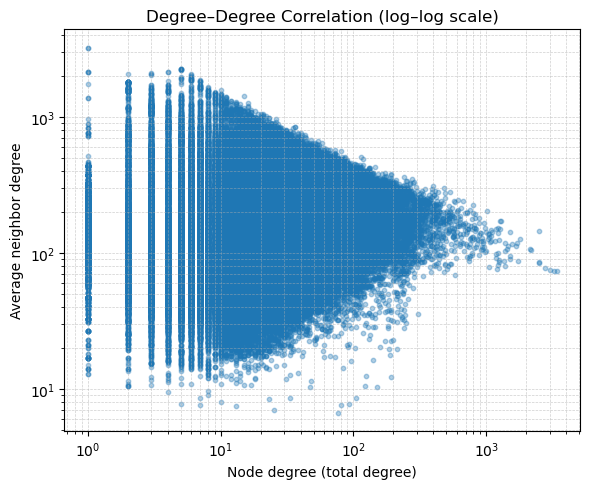

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# ------------------------------------------------------------
# Baseline assortativity on total degree
# (treating the directed graph as undirected)
# ------------------------------------------------------------

X_und = X.to_undirected()

r_total = nx.degree_assortativity_coefficient(X_und)

print("Degree assortativity coefficient (r) using total degree:")
print(f"  r = {r_total:.4f}")

# ------------------------------------------------------------
# Visual intuition: degree vs. average neighbor degree
# ------------------------------------------------------------

avg_neighbor_deg = nx.average_neighbor_degree(X_und)

deg = np.array([X_und.degree(n) for n in X_und.nodes()], dtype=float)
knn = np.array([avg_neighbor_deg[n] for n in X_und.nodes()], dtype=float)

# Remove zeros for log–log visualization
mask = (deg > 0) & (knn > 0)
deg = deg[mask]
knn = knn[mask]

plt.figure(figsize=(6, 5))
plt.scatter(deg, knn, s=10, alpha=0.35)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Node degree (total degree)")
plt.ylabel("Average neighbor degree")
plt.title("Degree–Degree Correlation (log–log scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

## Optional Extension: Directed Assortativity (In–In, Out–Out, etc.)

In directed graphs, degree–degree correlations can be defined in multiple ways.
For an edge $u \rightarrow v$, one may correlate, for example:

- out-degree of $u$ with in-degree of $v$,
- out-degree of $u$ with out-degree of $v$,
- in-degree of $u$ with in-degree of $v$.

These directed assortativity measures provide a richer picture of how
**activity** (out-degree) and **attention** (in-degree) interact along
directed links.